Name: Dhyan Navneeth V
Class: S6 ECE
Roll no: 25


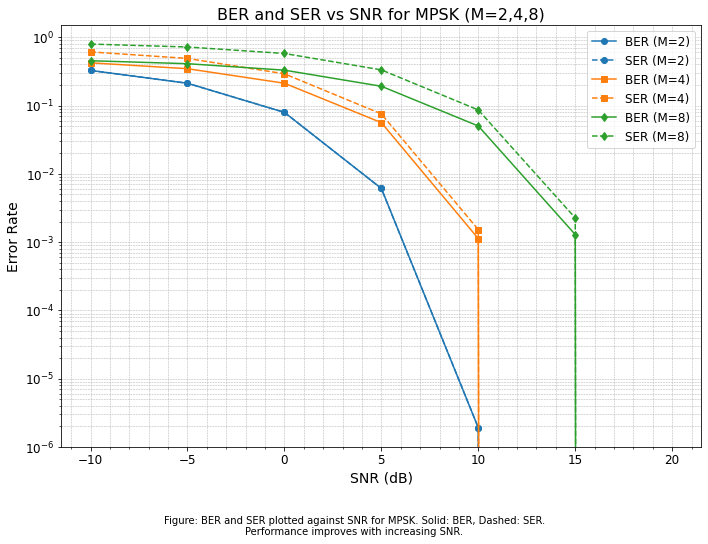

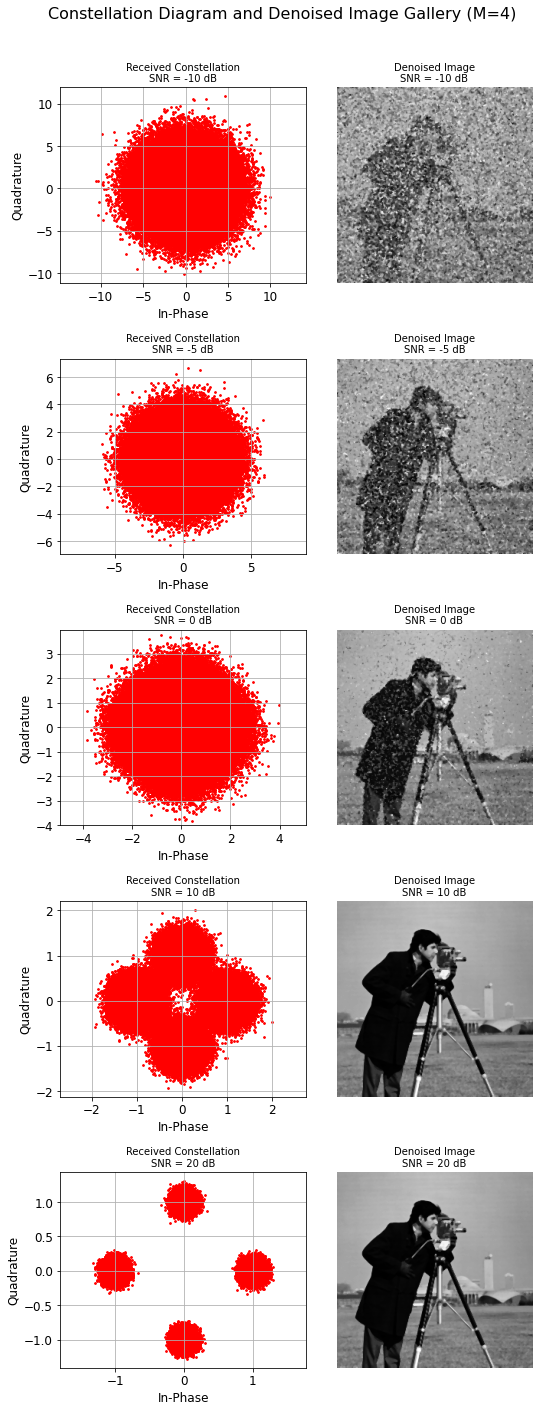

✅ All plots and galleries saved successfully!


In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import os

print("Name: Dhyan Navneeth V")
print("Class: S6 ECE")
print("Roll no: 25")

# ---------------------- Load Image ----------------------
image_path = r"G:\My Drive\KTU\S6\Comm LAB\cameraman.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

rows, cols = image.shape
image_flat = image.flatten()
image_binary = "".join([format(pixel, '08b') for pixel in image_flat])

# ---------------------- MPSK Parameters ----------------------
M_values = [2, 4, 8]  # BPSK, QPSK, 8-PSK
snr_values = np.arange(-10, 21, 5)
snr_showcase = [-10, -5, 0, 10, 20]

# ---------------------- Output Directory ----------------------
save_dir = r"G:\My Drive\KTU\S6\Comm LAB\MPSK plots"
os.makedirs(save_dir, exist_ok=True)

# ---------------------- Colors & Markers ----------------------
colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['o', 's', 'd']

# ---------- Containers ----------
ber_values_list = []
ser_values_list = []
constellations_gallery = []
images_gallery = []
titles_gallery = []

# ---------------------- Main Simulation ----------------------
for idx, M in enumerate(M_values):
    k = int(np.log2(M))
    symbols = np.exp(1j * 2 * np.pi * np.arange(M) / M)

    # Padding bits
    padding = (k - len(image_binary) % k) % k
    padded_binary = image_binary.ljust(len(image_binary) + padding, '0')

    # Group bits into symbols
    bit_groups = [padded_binary[i:i + k] for i in range(0, len(padded_binary), k)]
    symbol_indices = np.array([int(b, 2) for b in bit_groups])
    modulated_symbols = symbols[symbol_indices]

    # --------- Transmitted Constellation Diagram ---------
    if M == 4:
        plt.figure(figsize=(6,6))
        plt.scatter(modulated_symbols.real, modulated_symbols.imag, color='blue', s=1)
        plt.title("Transmitted Constellation (M=4)")
        plt.xlabel("In-Phase")
        plt.ylabel("Quadrature")
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "Transmitted_Constellation_M4.png"), dpi=300)
        plt.close()

    ber_values = []
    ser_values = []

    for snr_db in snr_values:
        snr_linear = 10 ** (snr_db / 10)
        noise_variance = 1 / (2 * snr_linear)
        noise = np.sqrt(noise_variance) * (np.random.randn(*modulated_symbols.shape) + 1j * np.random.randn(*modulated_symbols.shape))
        received = modulated_symbols + noise

        # Demodulation
        detected_indices = np.argmin(np.abs(received[:, None] - symbols[None, :]), axis=1)
        decoded_bits = "".join([format(i, f'0{k}b') for i in detected_indices])
        decoded_bits = decoded_bits[:len(image_binary)]

        # Image Reconstruction
        recovered_binary = [decoded_bits[i:i + 8] for i in range(0, len(decoded_bits), 8)]
        recovered_pixels = np.array([int(b, 2) for b in recovered_binary if len(b) == 8], dtype=np.uint8)
        recovered_image = recovered_pixels.reshape(rows, cols)
        recovered_image = median_filter(recovered_image, size=3)

        # BER & SER
        num_bit_errors = sum(1 for o, d in zip(image_binary, decoded_bits) if o != d)
        ber = num_bit_errors / len(image_binary)
        ber_values.append(ber)

        num_symbol_errors = np.sum(symbol_indices != detected_indices)
        ser = num_symbol_errors / len(symbol_indices)
        ser_values.append(ser)

        # ---------------------- Save Gallery Data ----------------------
        if M == 4 and snr_db in snr_showcase:
            constellations_gallery.append(received)
            images_gallery.append(recovered_image)
            titles_gallery.append(f"SNR = {snr_db} dB")

            # Save constellation
            plt.figure()
            plt.scatter(received.real, received.imag, color='red', s=1)
            plt.title(f"Received Constellation (M=4, SNR={snr_db} dB)")
            plt.xlabel("In-Phase")
            plt.ylabel("Quadrature")
            plt.grid(True)
            plt.axis('equal')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"Received_Constellation_M4_SNR_{snr_db}dB.png"), dpi=300)
            plt.close()

            # Save denoised image
            plt.figure()
            plt.imshow(recovered_image, cmap='gray')
            plt.title(f"Denoised Image (SNR={snr_db} dB)")
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f"Denoised_Image_M4_SNR_{snr_db}dB.png"), dpi=300)
            plt.close()

    ber_values_list.append(ber_values)
    ser_values_list.append(ser_values)

# ---------------------- BER & SER Plot ----------------------
plt.figure(figsize=(10,7))
for idx, M in enumerate(M_values):
    plt.semilogy(snr_values, ber_values_list[idx], marker=markers[idx], linestyle='-', color=colors[idx], label=f'BER (M={M})')
    plt.semilogy(snr_values, ser_values_list[idx], marker=markers[idx], linestyle='--', color=colors[idx], label=f'SER (M={M})')

plt.xlabel("SNR (dB)", fontsize=14)
plt.ylabel("Error Rate", fontsize=14)
plt.title("BER and SER vs SNR for MPSK (M=2,4,8)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.figtext(0.5, -0.07, "Figure: BER and SER plotted against SNR for MPSK. Solid: BER, Dashed: SER.\nPerformance improves with increasing SNR.", wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "BER_SER_vs_SNR_MPSK.png"), dpi=300, bbox_inches='tight')
plt.show()

# ---------------------- Clean Vertical Gallery ----------------------
n_samples = len(constellations_gallery)
plt.figure(figsize=(8, n_samples * 4))  # Dynamic height based on number of SNRs

for i in range(n_samples):
    # ---------- Constellation ----------
    plt.subplot(n_samples, 2, 2*i + 1)
    plt.scatter(constellations_gallery[i].real, constellations_gallery[i].imag, color='red', s=3)
    plt.title(f"Received Constellation\n{titles_gallery[i]}", fontsize=10)
    plt.xlabel("In-Phase")
    plt.ylabel("Quadrature")
    plt.axis('equal')
    plt.grid(True)

    # ---------- Denoised Image ----------
    plt.subplot(n_samples, 2, 2*i + 2)
    plt.imshow(images_gallery[i], cmap='gray')
    plt.title(f"Denoised Image\n{titles_gallery[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Constellation Diagram and Denoised Image Gallery (M=4)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(save_dir, "Vertical_Gallery_Cleaned_M4.png"), dpi=300)
plt.show()

print("✅ All plots and galleries saved successfully!")
